
<h1 class="notebook-title"> Using Packet Rate Data to Detect Ongoing DoS Attacks </h1>

In this notebook, we look to examine data on packets collected from vSocial, a Virtual Reality Learning Environment, during periods of normal activity along with samples collected during simulated DoS attacks (packet duplication, tampering, and dropping attacks). We first organize and restructure the data to get necessary statistics such as total packets sent over time and changes in packet speed over time, and we plot these measurements to compare discrepencies between each of the behaviors (normal vs. various DoS attacks). The final goal is to develop a detection algorithm that accurately classifies whether the current packet data implies normal behavior or the ongoing activities of one of the attacks. We use time series feature extraction to discover quantitative parameters from samples of packet speed over a period of time, and then are able to train various supervised machine learning models to attempt to classify a given situation. A variety of models are tested and compared for accuracy, and the most successful models for us were found to be implementations of K Nearest Neighbors, Random Forests, and a Voting Classifier combining the use of both.

<div class="outline">

----------------------------- Notebook Outline -----------------------------

<ul> 
    <br>

    <li>
        <a href="#Libraries">Libraries</a>
    </li>
    
    <br>
    
    <li>
        <a href="#Data">Data</a>
        <ul>
          <li><a href="#Data-a">A. Normal Behavior</a></li>
          <li><a href="#Data-b">B. Duplication Attack</a></li>
          <li><a href="#Data-c">C. Tampering Attack</a></li>
          <li><a href="#Data-d">D. Dropping Attack</a></li>
        </ul>
    </li>

    <br>
    
    <li>
        <a href="#Visualizations">Visualizations</a>
        <ul>
          <li>
              <a href="#Visualizations-a">A. Total Packets Sent Over Time</a>
              <ul>
                  <li><a href="#Visualizations-a-i">i. Normal Behavior</a></li>
                  <li><a href="#Visualizations-a-ii">ii. Duplication Attack</a></li>
                  <li><a href="#Visualizations-a-iii">iii. Tampering Attack</a></li>
                  <li><a href="#Visualizations-a-iv">iv. Dropping Attack</a></li>
              </ul>
          </li>
          <br>
          <li>
              <a href="#Visualizations-b">B. Packet Rate Changes Over Time</a>
              <ul>
                  <li><a href="#Visualizations-b-i">i. Normal Behavior</a></li>
                  <li><a href="#Visualizations-b-ii">ii. Duplication Attack</a></li>
                  <li><a href="#Visualizations-b-iii">iii. Tampering Attack</a></li>
                  <li><a href="#Visualizations-b-iv">iv. Dropping Attack</a></li>
              </ul>
          </li>
          <br>
          <li><a href="#Visualizations-c">C. Interactive Plot</a></li>
        </ul>
    </li>
    
    <br>
    
    <li>
        <a href="#Classifiers">Classifiers</a>
        <ul>
          <li>
              <a href="#Classifiers-a">A. Feature Extraction</a>
              <ul>
                  <li><a href="#Classifiers-a-i">i. tsfresh</a></li>
              </ul>
          </li>
          <br>
          <li>
              <a href="#Classifiers-b">B. Feature Filtering</a>
              <ul>
                  <li><a href="#Classifiers-b-i">i. tsfresh</a></li>
                  <li><a href="#Classifiers-b-ii">ii. Select K Best</a></li>
                  <li><a href="#Classifiers-b-iii">iii. Principal Component Analysis</a></li>
              </ul>
          </li>
          <br>
          <li>
              <a href="#Classifiers-c">C. Machine Learning Models</a>
              <ul>
                  <li><a href="#Classifiers-c-i">i. Decision Tree</a></li>
                  <li><a href="#Classifiers-c-ii">ii. Multilayer Perceptron (Neural Network)</a></li>
                  <li><a href="#Classifiers-c-iii">iii. SVC</a></li>
                  <li><a href="#Classifiers-c-iv">iv. Logistic Regression</a></li>
                  <li><a href="#Classifiers-c-v">v. K Nearest Neighbors</a></li>
                  <li><a href="#Classifiers-c-vi">vi. Random Forests</a></li>
                  <li><a href="#Classifiers-c-v">v. K Nearest Neighbors + Random Forests Voting</a></li>                  
              </ul>
          </li>
          <br>
        </ul>
    </li>
    
    <li>
        <a href="#Results">Results</a>
        <ul>
          <li>
              <a href="#Results-a">A. Decision Tree</a>
          </li>
          <li>
              <a href="#Results-b">B. K Nearest Neighbors</a>
          </li>
          <li>
              <a href="#Results-c">C. Random Forests</a>
          </li>
          <li>
              <a href="#Results-d">D. K Nearest Neighbors + Random Forests Voting</a>
          </li>
        </ul>
    </li>


</ul>

</div>

<h1 class="section-header"><a id="Libraries"></a>Libraries</h1>

In [229]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode, plot
init_notebook_mode(connected=True)

import random

from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

<h1 class="section-header"><a id="Data"></a>Data</h1>

<h1><a id="Data-a"></a>A. Normal Behavior</h1>

In [2]:
df_norm = pd.read_csv("vSocial_Norm_10mins.csv")
df_norm.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.147,128.206.20.43,UDP,83,64513 > 50495 Len=41
1,2,0.000022,128.206.20.147,128.206.20.43,QUIC,83,Protected Payload (KP0)
2,3,0.000035,128.206.20.147,128.206.20.43,UDP,83,64513 > 50497 Len=41
3,4,0.000048,128.206.20.147,128.206.20.43,UDP,83,64513 > 50496 Len=41
4,5,0.000061,128.206.20.147,128.206.20.43,UDP,83,64513 > 50500 Len=41


<h1><a id="Data-b"></a>B. Duplication Attack</h1>

In [3]:
df_dup = pd.read_csv("vSocial_Dup_10mins.csv")
df_dup.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
1,2,0.000210,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
2,3,0.000577,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
3,4,0.000921,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
4,5,0.001063,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90


<h1><a id="Data-c"></a>C. Tampering Attack</h1>

In [4]:
df_tamper = pd.read_csv("vSocial_Tamper_10mins.csv")
df_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.147,UDP,168,50496 > 64513 Len=126
1,2,0.000567,128.206.20.147,128.206.20.43,UDP,132,64513 > 62430 Len=90
2,3,0.004150,128.206.20.43,128.206.20.147,UDP,82,62430 > 64513 Len=40
3,4,0.004866,128.206.20.147,128.206.20.43,UDP,610,64513 > 50496 Len=568
4,5,0.010442,128.206.20.147,128.206.20.43,UDP,132,64513 > 62430 Len=90


<h1><a id="Data-d"></a>D. Dropping Attack</h1>

In [95]:
df_drop = pd.read_csv("vSocial_Drop_10mins.csv")
df_drop.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40
1,2,0.008214,128.206.20.43,128.206.20.147,UDP,709,50499 > 64513 Len=667
2,3,0.010326,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40
3,4,0.023819,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40
4,5,0.030320,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40


<h1><a id="Data-e"></a>E. Duplication + Dropping Attack</h1>

In [93]:
df_dup_drop = pd.read_csv("vSocial_Dup_Drop_10mins.csv")
df_dup_drop.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.46,128.206.20.43,UDP,614,58222 > 62057 Len=572
1,2,0.007095,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
2,3,0.012939,128.206.20.43,128.206.20.46,UDP,143,62057 > 58222 Len=101
3,4,0.016943,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
4,5,0.026106,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40


<h1><a id="Data-f"></a>F. Duplication + Tampering Attack</h1>

In [91]:
df_dup_tamper = pd.read_csv("vSocial_Dup_Tamper_10mins.csv")
df_dup_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.46,128.206.20.43,UDP,626,58222 > 53290 Len=584
1,2,0.000713,128.206.20.46,128.206.20.43,UDP,626,58222 > 53290 Len=584
2,3,0.001075,128.206.20.43,128.206.20.46,UDP,198,53291 > 58222 Len=156
3,4,0.001075,128.206.20.43,128.206.20.46,UDP,198,53291 > 58222 Len=156
4,5,0.001196,128.206.20.46,128.206.20.43,UDP,626,58222 > 53290 Len=584


<h1><a id="Data-g"></a>G. Dropping + Tampering Attack</h1>

In [89]:
df_drop_tamper = pd.read_csv("vSocial_Drop_Tamper_10mins.csv")
df_drop_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
1,2,0.002915,128.206.20.46,128.206.20.43,UDP,132,58222 > 62053 Len=90
2,3,0.011434,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
3,4,0.019637,128.206.20.43,128.206.20.46,UDP,143,62057 > 58222 Len=101
4,5,0.019637,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40


<h1><a id="Data-h"></a>H. Dropping + Duplication + Tampering Attack</h1>

In [87]:
df_drop_dup_tamper = pd.read_csv("vSocial_Drop_Dup_Tamper_10mins.csv")
df_drop_dup_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40
1,2,0.009997,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40
2,3,0.012511,128.206.20.43,128.206.20.46,UDP,143,63271 > 54854 Len=101
3,4,0.019995,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40
4,5,0.029499,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40


<h1 class="section-header"><a id="Visualizations"></a>Visualizations</h1>

In [6]:
def getPacketsSent(df):
    speedArray = []
    for i in range(0, 600):
        speedArray.append(len(df[df.Time <= i+1]))
    return speedArray

In [7]:
def getPacketSpeeds(df):
    speedArray = []
    for i in range(0, 600):
        speedArray.append(len(df[(df.Time >= i) & (df.Time <= i+1)]))
    return speedArray

<h1><a id="Visualizations-a"></a>A. Total Packets Sent Over Time</h1>

<h2><a id="Visualizations-a-i"></a>i. Normal Behavior</h2>

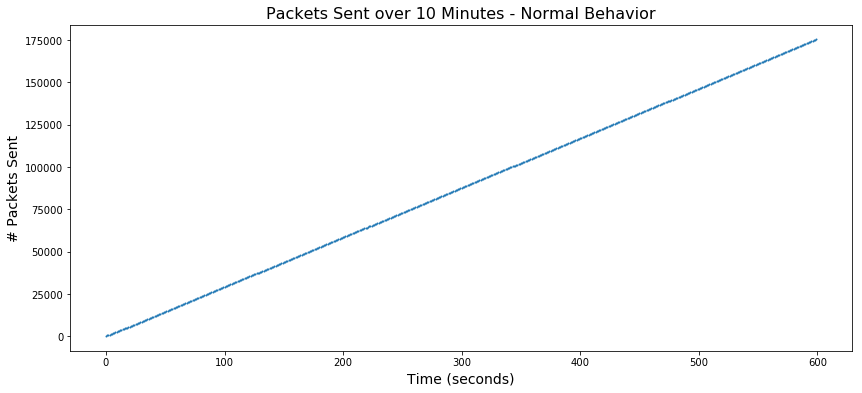

In [8]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_norm), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Normal Behavior", fontsize=16)
plt.show()

In [9]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_norm))]

layout = dict(
    title="Packets Sent over 10 Minutes - Normal Behavior",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-ii"></a>ii. Duplication Attack</h2>

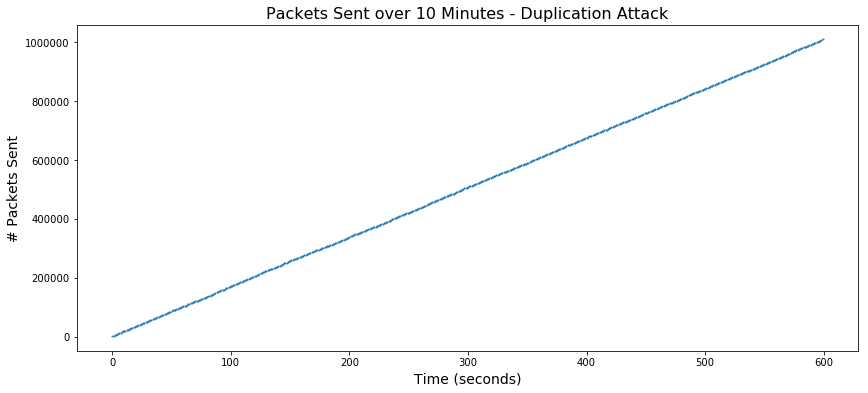

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_dup), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Duplication Attack", fontsize=16)
plt.show()

In [11]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_dup))]

layout = dict(
    title="Packets Sent over 10 Minutes - Duplication Attack",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-iii"></a>iii. Tampering Attack</h2>

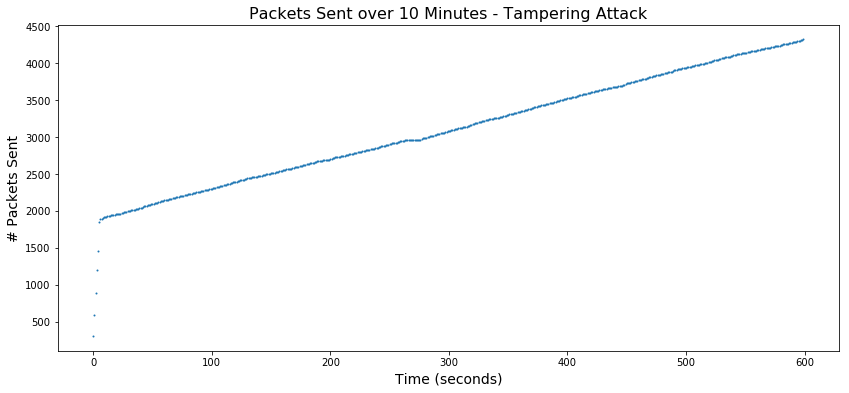

In [12]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Tampering Attack", fontsize=16)
plt.show()

In [13]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_tamper))]

layout = dict(
    title="Packets Sent over 10 Minutes - Tampering Attack",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-iv"></a>iv. Dropping Attack</h2>

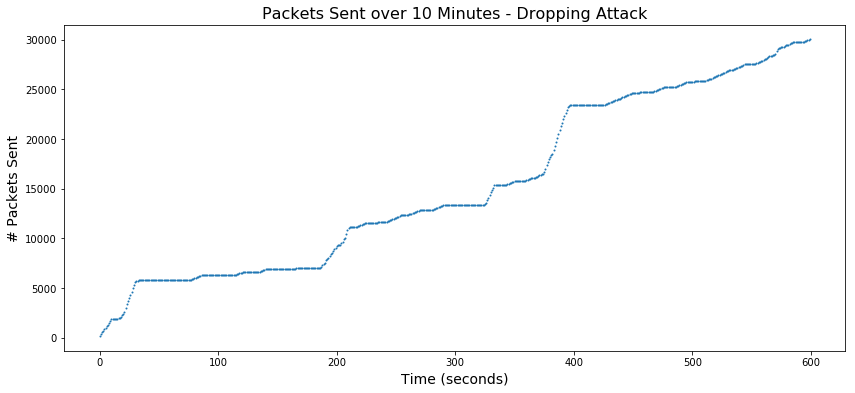

In [14]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_drop), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Dropping Attack", fontsize=16)
plt.show()

In [15]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_drop))]

layout = dict(
    title="Packets Sent over 10 Minutes - Dropping Attack",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-v"></a>v. Duplication + Dropping Attack</h2>

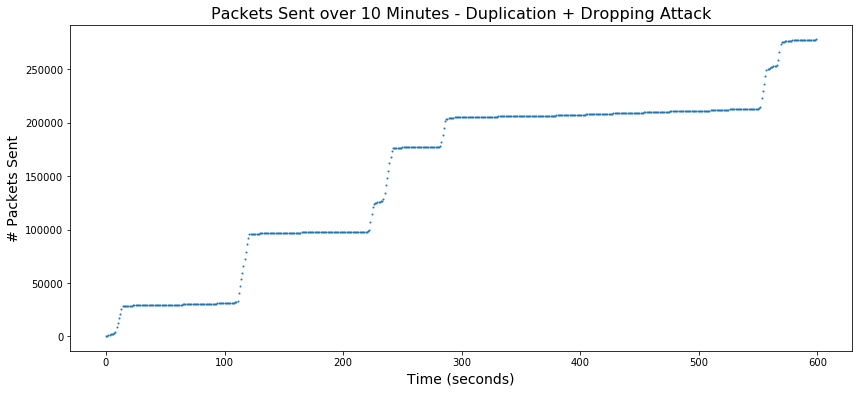

In [65]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_dup_drop), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Duplication + Dropping Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-a-vi"></a>vi. Duplication + Tampering Attack</h2>

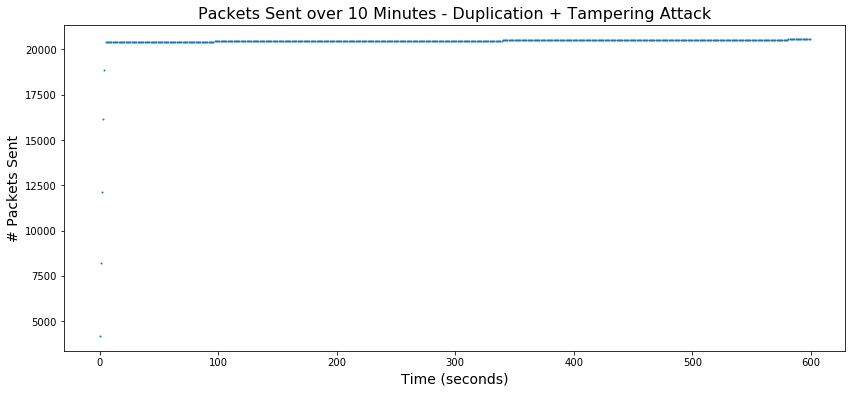

In [71]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_dup_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Duplication + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-a-vii"></a>vii. Dropping + Tampering Attack</h2>

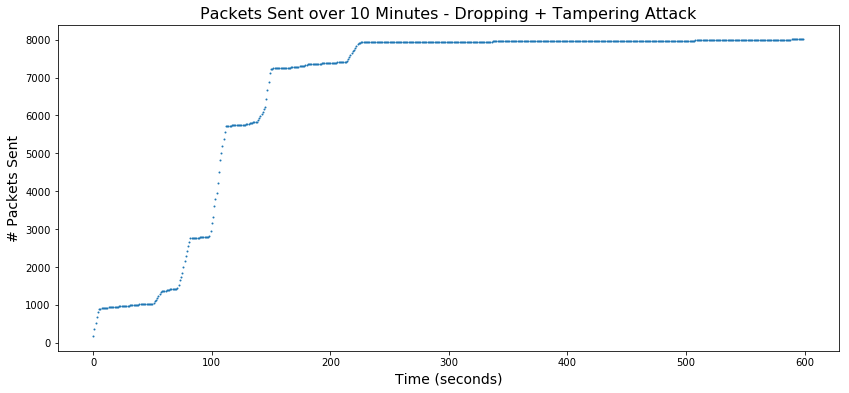

In [73]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_drop_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Dropping + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-a-viii"></a>viii. Dropping + Duplication + Tampering Attack</h2>

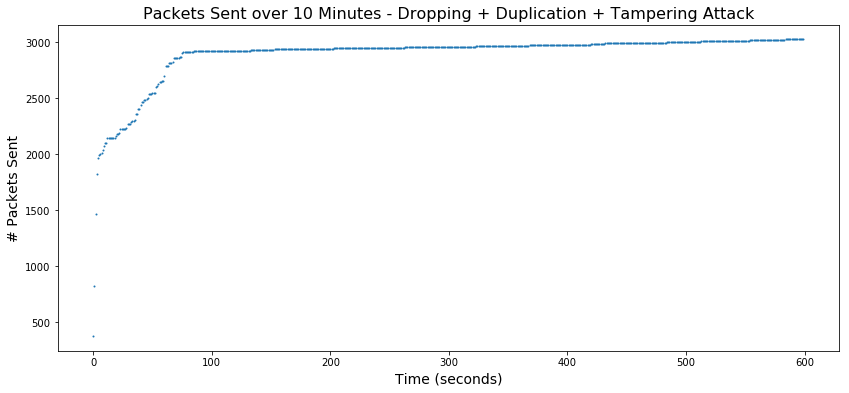

In [76]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_drop_dup_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Dropping + Duplication + Tampering Attack", fontsize=16)
plt.show()

<h1><a id="Visualizations-b"></a>B. Packet Rate Changes Over Time</h1>

<h2><a id="Visualizations-b-i"></a>i. Normal Behavior</h2>

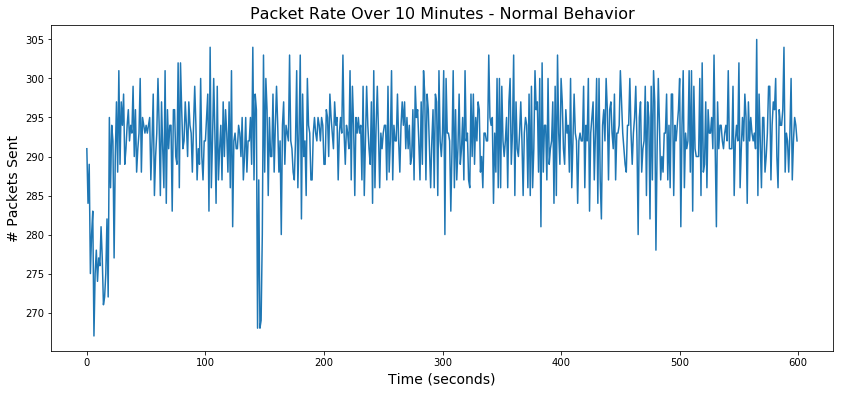

In [16]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_norm), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Normal Behavior", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-ii"></a>ii. Duplication Attack</h2>

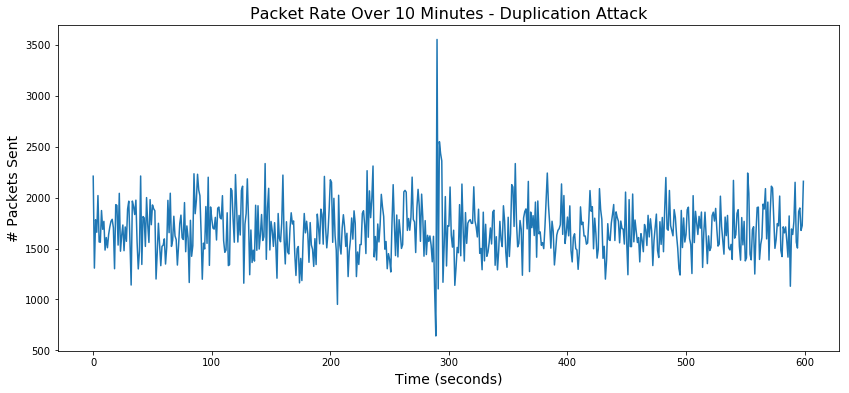

In [17]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_dup), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Duplication Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-iii"></a>iii. Tampering Attack</h2>

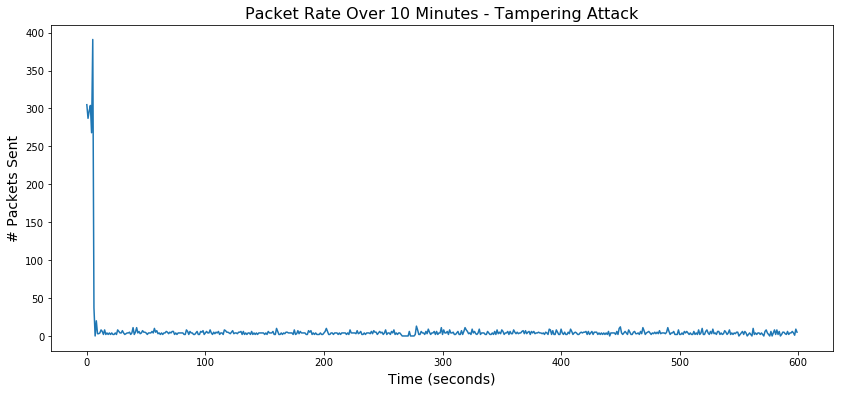

In [18]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-iv"></a>iv. Dropping Attack</h2>

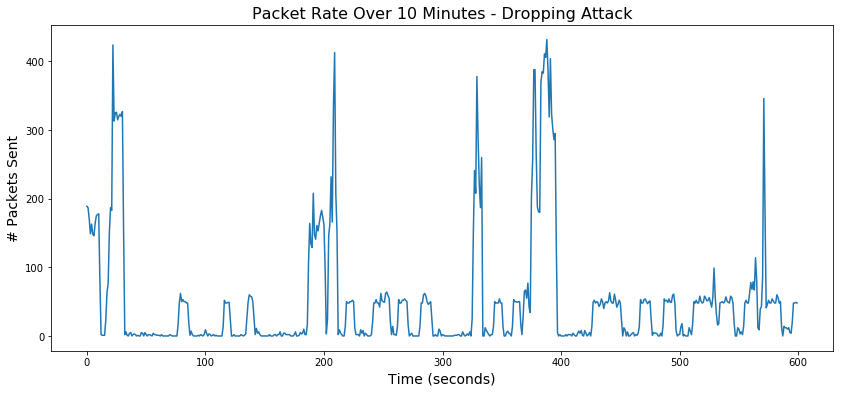

In [19]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_drop), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Dropping Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-v"></a>v. Duplication + Dropping Attack</h2>

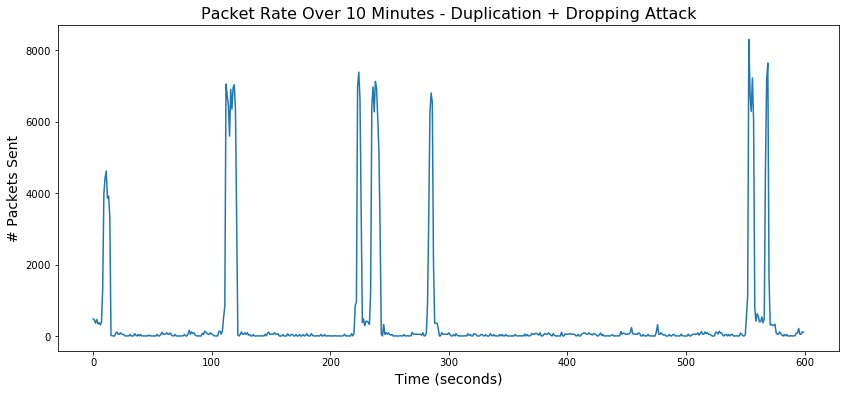

In [70]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_dup_drop), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Duplication + Dropping Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-vi"></a>vi. Duplication + Tampering Attack</h2>

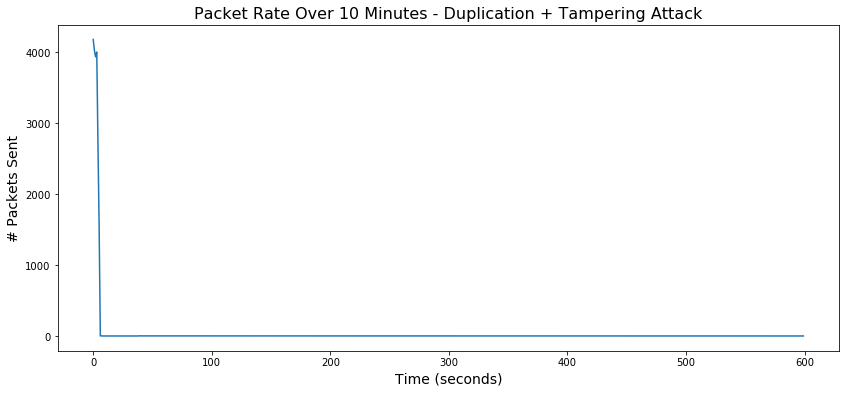

In [72]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_dup_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Duplication + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-vii"></a>vii. Dropping + Tampering Attack</h2>

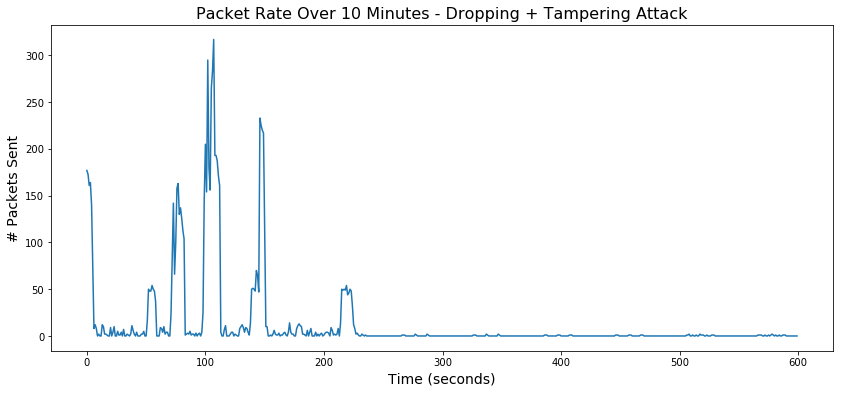

In [74]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_drop_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Dropping + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-viii"></a>viii. Dropping + Duplication + Tampering Attack</h2>

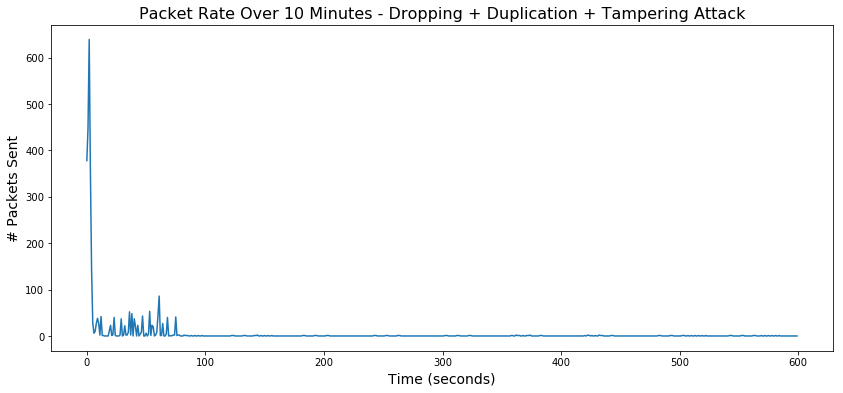

In [77]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_drop_dup_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Dropping + Duplication + Tampering Attack", fontsize=16)
plt.show()

<h1><a id="Visualizations-c"></a>C. Interactive Plot</h1>

In [20]:
def updateVisibility(selected_type):
    visibilityValues = []
    for plot_datum in plot_data:
        if plot_datum['Type'] == selected_type:
            visibilityValues.append(True)
        else:
            visibilityValues.append(False)
    return visibilityValues

norm_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_norm)}
dup_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_dup)}
tamper_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_tamper)}
drop_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_drop)}

norm_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_norm)}
dup_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_dup)}
tamper_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_tamper)}
drop_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_drop)}

data = []
buttons_data = []
buttons_labels = ["Total Packets Sent", "Packet Speed"]
plot_data = [{"Title": "No Manipulation", "Type": "Total Packets Sent", "Data": norm_total, "Color": "rgb(77, 82, 91)"}, 
             {"Title": "Duplication", "Type": "Total Packets Sent", "Data": dup_total, "Color": "rgb(104, 156, 249)"}, 
             {"Title": "Tampering", "Type": "Total Packets Sent", "Data": tamper_total, "Color": "rgb(249, 104, 104)"}, 
             {"Title": "Dropping", "Type": "Total Packets Sent", "Data": drop_total, "Color": "rgb(104, 249, 133)"},
             {"Title": "No Manipulation", "Type": "Packet Speed", "Data": norm_speed, "Color": "rgb(77, 82, 91)"}, 
             {"Title": "Duplication", "Type": "Packet Speed", "Data": dup_speed, "Color": "rgb(104, 156, 249)"}, 
             {"Title": "Tampering", "Type": "Packet Speed", "Data": tamper_speed, "Color": "rgb(249, 104, 104)"}, 
             {"Title": "Dropping", "Type": "Packet Speed", "Data": drop_speed, "Color": "rgb(104, 249, 133)"}]

for button_label in buttons_labels:
    buttons_data.append(dict(
        label = button_label,
        method = 'update',
        args = [{'visible': updateVisibility(button_label)}]
    ))
    
for plot_datum in plot_data:
    data.append(go.Scatter(
        x=plot_datum["Data"]["x"],
        y=plot_datum["Data"]["y"],
        mode='lines+markers',
        line=dict(
            color=plot_datum["Color"],
            width=1
        ),
        marker = dict(
            size = 1
        ),
        name=plot_datum["Title"],
        text=plot_datum["Title"],
        visible=(plot_datum["Type"]=='Total Packets Sent')
    ))
    

updatemenus = list([
    dict(active=0,
         buttons= buttons_data,
         direction = 'down',
         pad = {'r': 10, 't': 10},
         showactive = True,
         x = 0,
         xanchor = 'center',
         y = 1.3,
         yanchor = 'top'
    )
])
    
layout = dict(
    title='Packet Monitoring',
    updatemenus = updatemenus,
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(),
        autorange=True
    ),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [21]:
plot(fig, filename='chart10mins.html')

'chart10mins.html'

<h1 class="section-header"><a id="Classifiers"></a>Classifiers</h1>

<h1><a id="Classifiers-a"></a>A. Feature Extraction</h1>

<h2><a id="Classifiers-a-i"></a>i. tsfresh</h2>

In [22]:
dataframes = [{'data':df_norm, 'y_value':"Normal"}, {'data':df_tamper, 'y_value':"Tamper"}, {'data':df_dup, 'y_value':"Duplication"}, {'data':df_drop, 'y_value':"Dropping"}]
y_store = []
df_store = []
sample_id = 0
for df_i in range(len(dataframes)):
    y_val = dataframes[df_i]['y_value']
    for chunk in np.split(np.array(getPacketSpeeds(dataframes[df_i]['data'])), 40):
        y_store.append(y_val)
        for chunk_i in range(len(chunk)):
            df_store.append({'id':sample_id, 'time':chunk_i, 'val':chunk[chunk_i]})
        sample_id += 1

df = pd.DataFrame(df_store)
y = pd.Series(y_store)

In [23]:
df

,id,time,val
0,0,0,291
1,0,1,284
2,0,2,289
3,0,3,275
4,0,4,280
5,0,5,283
6,0,6,267
7,0,7,275
8,0,8,278
9,0,9,274


In [24]:
y

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
5        Normal
6        Normal
7        Normal
8        Normal
9        Normal
10       Normal
11       Normal
12       Normal
13       Normal
14       Normal
15       Normal
16       Normal
17       Normal
18       Normal
19       Normal
20       Normal
21       Normal
22       Normal
23       Normal
24       Normal
25       Normal
26       Normal
27       Normal
28       Normal
29       Normal
         ...   
130    Dropping
131    Dropping
132    Dropping
133    Dropping
134    Dropping
135    Dropping
136    Dropping
137    Dropping
138    Dropping
139    Dropping
140    Dropping
141    Dropping
142    Dropping
143    Dropping
144    Dropping
145    Dropping
146    Dropping
147    Dropping
148    Dropping
149    Dropping
150    Dropping
151    Dropping
152    Dropping
153    Dropping
154    Dropping
155    Dropping
156    Dropping
157    Dropping
158    Dropping
159    Dropping
Length: 160, dtype: obje

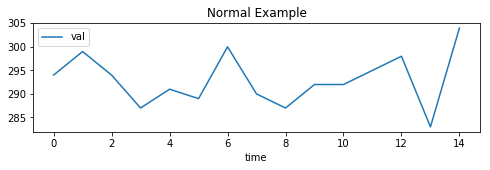

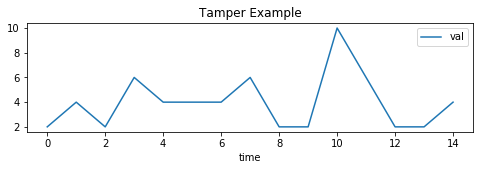

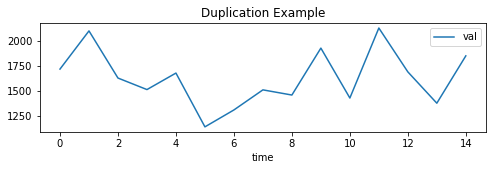

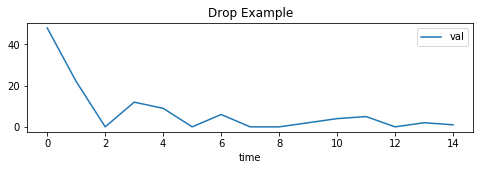

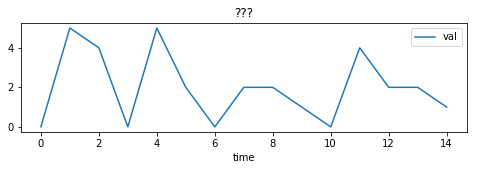

In [25]:
df[df.id == 6][['time', 'val']].plot(x='time', title='Normal Example', figsize=(8, 2));
df[df.id == 50][['time', 'val']].plot(x='time', title='Tamper Example', figsize=(8, 2));
df[df.id == 100][['time', 'val']].plot(x='time', title='Duplication Example', figsize=(8, 2));
df[df.id == 150][['time', 'val']].plot(x='time', title='Drop Example', figsize=(8, 2));
df[df.id == 123][['time', 'val']].plot(x='time', title='???', figsize=(8, 2));

In [26]:
extraction_settings = ComprehensiveFCParameters()

In [27]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.25s/it]
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'

 'val__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [28]:
X.head()

variable,val__abs_energy,val__absolute_sum_of_changes,"val__agg_autocorrelation__f_agg_""mean""__maxlag_40","val__agg_autocorrelation__f_agg_""median""__maxlag_40","val__agg_autocorrelation__f_agg_""var""__maxlag_40","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","val__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,val__symmetry_looking__r_0.9,val__symmetry_looking__r_0.9500000000000001,val__time_reversal_asymmetry_statistic__lag_1,val__time_reversal_asymmetry_statistic__lag_2,val__time_reversal_asymmetry_statistic__lag_3,val__value_count__value_-1,val__value_count__value_0,val__value_count__value_1,val__variance,val__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1164282.0,84.0,-0.318277,-0.084787,0.458073,291.0,-1.0,-10.0,0.0,0.0,...,1.0,1.0,-327310.538462,-4.920471e+05,-8.003561e+05,0.0,0.0,0.0,37.982222,1.0
1,1237951.0,139.0,-0.360882,-0.189682,0.396928,295.0,1.0,6.0,0.0,0.0,...,1.0,1.0,481305.307692,1.094408e+06,1.451703e+06,0.0,0.0,0.0,84.515556,1.0
2,1289634.0,61.0,-0.067411,-0.174145,0.118556,299.0,-1.0,-3.0,0.0,0.0,...,1.0,1.0,-106346.230769,-6.222636e+04,-9.548111e+04,0.0,0.0,0.0,9.360000,1.0
3,1285611.0,65.0,-0.107310,-0.109689,0.281267,300.0,-1.0,-2.0,0.0,0.0,...,1.0,1.0,-65854.923077,-1.725083e+05,-3.579941e+05,0.0,0.0,0.0,14.595556,1.0
4,1284094.0,114.0,0.000876,0.012714,0.255850,301.0,-1.0,-5.0,0.0,0.0,...,1.0,1.0,-27088.615385,-1.081755e+05,1.350256e+04,0.0,0.0,0.0,30.515556,1.0


<h1><a id="Classifiers-b"></a>B. Feature Filtering</h1>

<h2><a id="Classifiers-b-i"></a>i. tsfresh</h2>

In [29]:
X_filtered = extract_relevant_features(df, y, 
                                       column_id='id', column_sort='time',
                                       default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.18s/it]
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'

 'val__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [30]:
X_filtered.head()

variable,"val__fft_aggregated__aggtype_""variance""","val__fft_aggregated__aggtype_""centroid""",val__sum_of_reoccurring_data_points,val__sum_of_reoccurring_values,"val__fft_aggregated__aggtype_""skew""","val__fft_aggregated__aggtype_""kurtosis""",val__autocorrelation__lag_1,val__partial_autocorrelation__lag_1,val__cid_ce__normalize_True,val__sample_entropy,...,"val__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",val__symmetry_looking__r_0.30000000000000004,val__ratio_value_number_to_time_series_length,val__has_duplicate_max,"val__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","val__fft_coefficient__coeff_1__attr_""real""",val__percentage_of_reoccurring_datapoints_to_all_datapoints,"val__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6",val__percentage_of_reoccurring_values_to_all_values,"val__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4"
id,,,,,,,,,,,,,,,,,,,,,
0,0.671843,0.138928,1104.0,552.0,6.510976,45.365282,0.179875,0.179875,4.401987,2.169054,...,3.0,1.0,0.866667,0.0,0.0,31.847458,0.153846,0.0,0.266667,0.0
1,0.918603,0.189438,1138.0,569.0,5.584250,33.551005,0.199497,0.199497,4.533479,3.044522,...,2.0,1.0,0.866667,0.0,0.0,-27.783688,0.153846,0.0,0.266667,0.0
2,0.405701,0.077271,2642.0,1174.0,1.832407,6.058999,-0.323871,-0.323871,6.244656,2.862201,...,2.0,1.0,0.666667,0.0,0.0,-6.051522,0.400000,0.0,0.600000,0.0
3,0.502010,0.097991,2351.0,882.0,7.741466,63.330613,-0.347486,-0.347486,6.008900,2.708050,...,1.0,1.0,0.666667,0.0,0.0,0.997040,0.300000,1.0,0.533333,0.0
4,0.699398,0.136813,2352.0,881.0,6.489552,44.494378,-0.534039,-0.534039,6.536995,2.014903,...,0.0,1.0,0.666667,0.0,0.0,9.573739,0.300000,0.0,0.533333,0.0


<h2><a id="Classifiers-b-ii"></a>ii. Select K Best</h2>

In [31]:
X_filtered_2 = SelectKBest(f_classif, k=50).fit_transform(X_filtered, y)
print(X_filtered.shape)
print(X_filtered_2.shape)
X_filtered_2

(160, 212)
(160, 50)


array([[ 272.2       ,  274.8       ,  275.2       , ...,  401.25885647,
         280.8       ,  283.2       ],
       [ 273.2       ,  276.6       ,  282.8       , ...,  423.71216657,
         293.6       ,  295.4       ],
       [ 289.4       ,  290.8       ,  291.2       , ...,  425.66712629,
         294.        ,  296.        ],
       ..., 
       [  22.8       ,   42.2       ,   48.        , ...,   78.48265541,
          67.8       ,   78.2       ],
       [  46.8       ,   48.        ,   48.        , ...,   75.13098604,
          55.6       ,   65.2       ],
       [   4.4       ,    9.        ,   12.        , ...,   44.0637317 ,
          42.4       ,   48.        ]])

<h2><a id="Classifiers-b-iii"></a>iii. Principal Component Analysis</h2>

In [32]:
pca = PCA(n_components=50)
X_filtered_3 = pca.fit_transform(X_filtered) 
X_filtered_3

array([[ -2.05223484e+09,   2.56237603e+06,   2.13435274e+05, ...,
         -3.64750007e+01,  -2.07352820e+01,   3.15610363e+01],
       [ -2.04803607e+09,   2.70858182e+06,   2.40720007e+05, ...,
         -3.12661514e+01,  -1.70694284e+01,   2.96950226e+01],
       [ -2.04564771e+09,   2.71642678e+06,   7.84811935e+04, ...,
          1.44704811e+00,   9.82862778e+00,   8.15848905e+00],
       ..., 
       [ -2.08895470e+09,   2.85420781e+06,   1.19237786e+05, ...,
         -1.10978424e+01,   1.64090248e+01,  -4.51865471e+01],
       [ -2.08861808e+09,   2.47247340e+06,   1.34176037e+05, ...,
         -7.19708175e+00,   7.10367702e+00,   1.49674277e+01],
       [ -2.08931805e+09,   2.86206431e+06,   1.08804860e+05, ...,
         -3.02228823e+01,   1.58721085e+02,   1.13884901e+01]])

<h1><a id="Classifiers-c"></a>C. Machine Learning Models</h1>

<h2><a id="Classifiers-c-i"></a>i. Decision Tree</h2>

In [33]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

    Dropping       0.93      0.88      0.90        16
 Duplication       1.00      1.00      1.00        13
      Normal       1.00      1.00      1.00        13
      Tamper       0.91      0.95      0.93        22

    accuracy                           0.95        64
   macro avg       0.96      0.96      0.96        64
weighted avg       0.95      0.95      0.95        64



In [34]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

              precision    recall  f1-score   support

    Dropping       1.00      0.92      0.96        12
 Duplication       1.00      0.96      0.98        24
      Normal       1.00      1.00      1.00        13
      Tamper       0.88      1.00      0.94        15

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



In [35]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_2, y, test_size=.4)
cl6 = DecisionTreeClassifier()
cl6.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl6.predict(X_filtered_test)))

              precision    recall  f1-score   support

    Dropping       0.94      0.79      0.86        19
 Duplication       1.00      1.00      1.00        13
      Normal       0.94      1.00      0.97        17
      Tamper       0.82      0.93      0.87        15

    accuracy                           0.92        64
   macro avg       0.93      0.93      0.93        64
weighted avg       0.93      0.92      0.92        64



In [36]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_3, y, test_size=.4)
cl6 = DecisionTreeClassifier()
cl6.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl6.predict(X_filtered_test)))

              precision    recall  f1-score   support

    Dropping       0.93      0.78      0.85        18
 Duplication       1.00      1.00      1.00        11
      Normal       0.95      0.95      0.95        20
      Tamper       0.83      1.00      0.91        15

    accuracy                           0.92        64
   macro avg       0.93      0.93      0.93        64
weighted avg       0.93      0.92      0.92        64



<h2><a id="Classifiers-c-ii"></a>ii. Multilayer Perceptron (Neural Network)</h2>

In [37]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
scaler = StandardScaler()  
scaler.fit(X_filtered_train) 
cl5 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
cl5.fit(scaler.transform(X_filtered_train), y_train)
print(classification_report(y_test, cl5.predict(scaler.transform(X_filtered_test))))

              precision    recall  f1-score   support

    Dropping       0.95      0.95      0.95        19
 Duplication       1.00      1.00      1.00        13
      Normal       1.00      1.00      1.00        17
      Tamper       0.93      0.93      0.93        15

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



<h2><a id="Classifiers-c-iii"></a>iii. SVC</h2>

In [38]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl8 = SVC(gamma='scale')
cl8.fit(X_train, y_train)
print(classification_report(y_test, cl8.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

    Dropping       0.00      0.00      0.00        17
 Duplication       1.00      1.00      1.00        15
      Normal       0.29      1.00      0.44        14
      Tamper       0.00      0.00      0.00        18

    accuracy                           0.45        64
   macro avg       0.32      0.50      0.36        64
weighted avg       0.30      0.45      0.33        64



<h2><a id="Classifiers-c-iv"></a>iv. Logistic Regression</h2>

In [39]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl9 = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_filtered_train, y_train)
print(classification_report(y_test, cl9.predict(X_filtered_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

    Dropping       0.89      0.53      0.67        15
 Duplication       1.00      1.00      1.00        13
      Normal       0.38      1.00      0.55        16
      Tamper       0.00      0.00      0.00        20

    accuracy                           0.58        64
   macro avg       0.57      0.63      0.55        64
weighted avg       0.51      0.58      0.50        64



<h2><a id="Classifiers-c-v"></a>v. K Nearest Neighbors</h2>

In [40]:
avg_precision = []
avg_recall = []
for k in range(2, 20):
    print("Testing k =", k)
    precision_scores = []
    recall_scores = []
    for i in range(1000):
        X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
        cl10 = KNeighborsClassifier(n_neighbors=k)
        cl10.fit(X_filtered_train, y_train)
        precision_scores.append(precision_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
        recall_scores.append(recall_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
    avg_precision.append(np.array(precision_scores).mean())
    avg_recall.append(np.array(recall_scores).mean())  

Testing k = 2
Testing k = 3
Testing k = 4
Testing k = 5
Testing k = 6
Testing k = 7
Testing k = 8
Testing k = 9
Testing k = 10
Testing k = 11
Testing k = 12
Testing k = 13
Testing k = 14
Testing k = 15
Testing k = 16
Testing k = 17
Testing k = 18
Testing k = 19


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.



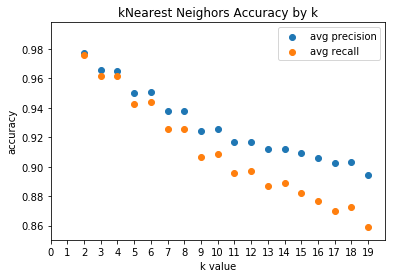

In [41]:
plt.title('kNearest Neighors Accuracy by k')
plt.scatter(range(2, 20), avg_precision, label="avg precision")
plt.scatter(range(2, 20), avg_recall, label="avg recall")
plt.xticks(range(0, 20))
plt.xlabel("k value")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [42]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl10 = KNeighborsClassifier(n_neighbors=2)
cl10.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl10.predict(X_filtered_test)))

              precision    recall  f1-score   support

    Dropping       0.94      0.89      0.91        18
 Duplication       1.00      1.00      1.00        14
      Normal       0.88      1.00      0.94        15
      Tamper       1.00      0.94      0.97        17

    accuracy                           0.95        64
   macro avg       0.96      0.96      0.96        64
weighted avg       0.96      0.95      0.95        64



<h2><a id="Classifiers-c-vi"></a>vi. Random Forests</h2>

In [43]:
avg_precision = []
avg_recall = []
for n in range(2, 20):
    print("Testing n =", n)
    precision_scores = []
    recall_scores = []
    for i in range(1000):
        X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
        cl11 = RandomForestClassifier(n_estimators=n, max_depth=None,
                                      min_samples_split=2)
        cl11.fit(X_filtered_train, y_train)
        precision_scores.append(precision_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
        recall_scores.append(recall_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
    avg_precision.append(np.array(precision_scores).mean())
    avg_recall.append(np.array(recall_scores).mean())  

Testing n = 2
Testing n = 3
Testing n = 4
Testing n = 5
Testing n = 6
Testing n = 7
Testing n = 8
Testing n = 9
Testing n = 10
Testing n = 11
Testing n = 12
Testing n = 13
Testing n = 14
Testing n = 15
Testing n = 16
Testing n = 17
Testing n = 18
Testing n = 19


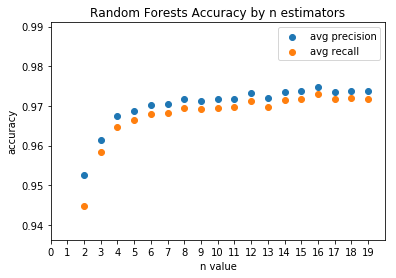

In [44]:
plt.title('Random Forests Accuracy by n estimators')
plt.scatter(range(2, 20), avg_precision, label="avg precision")
plt.scatter(range(2, 20), avg_recall, label="avg recall")
plt.xticks(range(0, 20))
plt.xlabel("n value")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [45]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                              min_samples_split=2, random_state=0)
cl11.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl11.predict(X_filtered_test)))

              precision    recall  f1-score   support

    Dropping       1.00      0.95      0.98        21
 Duplication       1.00      1.00      1.00        15
      Normal       0.94      1.00      0.97        16
      Tamper       1.00      1.00      1.00        12

    accuracy                           0.98        64
   macro avg       0.99      0.99      0.99        64
weighted avg       0.99      0.98      0.98        64



<h2><a id="Classifiers-c-vii"></a>vii. K Nearest Neighbors + Random Forests Voting</h2>

In [46]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl10 = KNeighborsClassifier(n_neighbors=2)
cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                              min_samples_split=2)
cl12 = VotingClassifier(estimators=[('lr', cl10), ('rf', cl11)],
                        voting='soft')
cl12.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl12.predict(X_filtered_test)))

              precision    recall  f1-score   support

    Dropping       1.00      0.90      0.95        21
 Duplication       1.00      1.00      1.00        15
      Normal       0.94      1.00      0.97        17
      Tamper       0.92      1.00      0.96        11

    accuracy                           0.97        64
   macro avg       0.97      0.98      0.97        64
weighted avg       0.97      0.97      0.97        64



<h1 class="section-header"><a id="Results"></a>Results</h1>

<h1><a id="Results-a"></a>A. Decision Tree</h1>

In [47]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl = DecisionTreeClassifier()
    cl.fit(X_train, y_train)
    precision_scores.append(precision_score(y_test, cl.predict(X_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl.predict(X_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

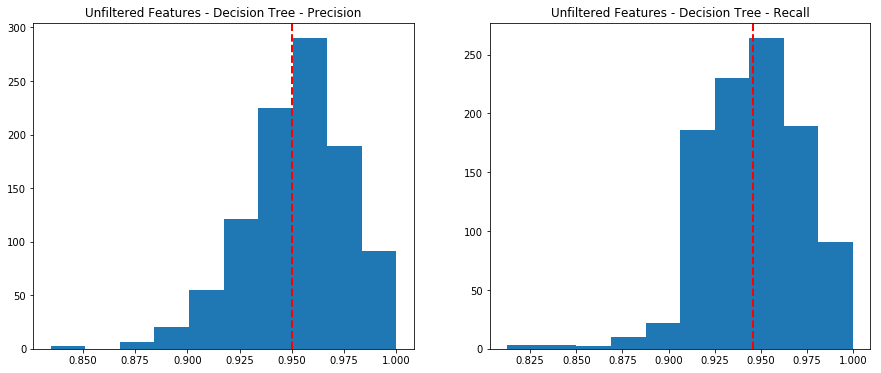

In [48]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Unfiltered Features - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Unfiltered Features - Decision Tree - Recall")
plt.show()

In [49]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl2 = DecisionTreeClassifier()
    cl2.fit(X_filtered_train, y_train)
    precision_scores.append(precision_score(y_test, cl2.predict(X_filtered_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl2.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

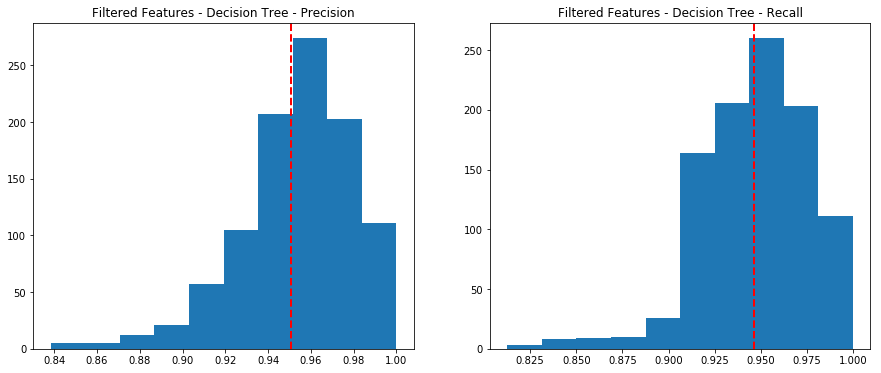

In [50]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Decision Tree - Recall")
plt.show()

In [51]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_2, y, test_size=.4)
    cl6 = DecisionTreeClassifier()
    cl6.fit(X_filtered_train, y_train)
    precision_scores.append(precision_score(y_test, cl6.predict(X_filtered_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl6.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

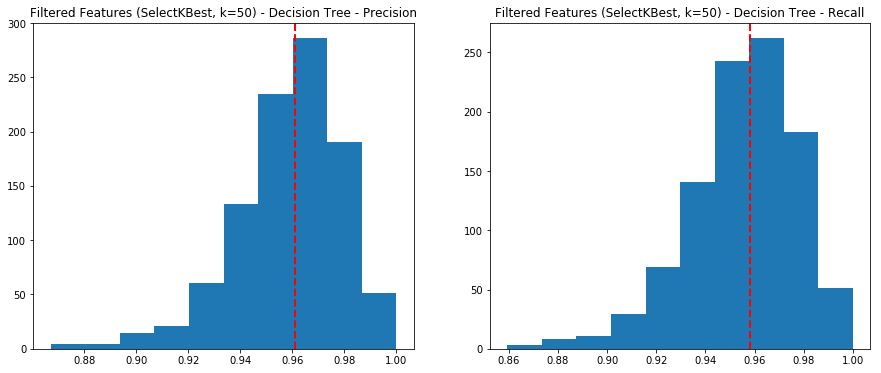

In [52]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (SelectKBest, k=50) - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (SelectKBest, k=50) - Decision Tree - Recall")
plt.show()

In [53]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_3, y, test_size=.4)
    cl7 = DecisionTreeClassifier()
    cl7.fit(X_filtered_train, y_train)
    precision_scores.append(precision_score(y_test, cl7.predict(X_filtered_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl7.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

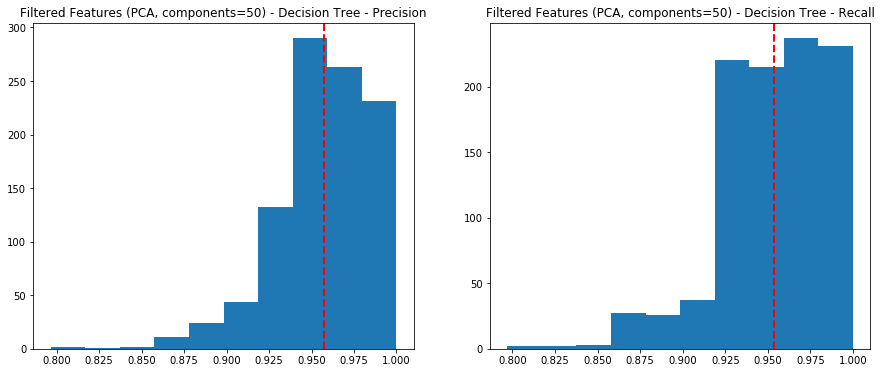

In [54]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (PCA, components=50) - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (PCA, components=50) - Decision Tree - Recall")
plt.show()

<h1><a id="Results-b"></a>B. K Nearest Neighbors</h1>

In [55]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl10 = KNeighborsClassifier(n_neighbors=2)
    cl10.fit(X_filtered_train, y_train)
    precision_scores.append(precision_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

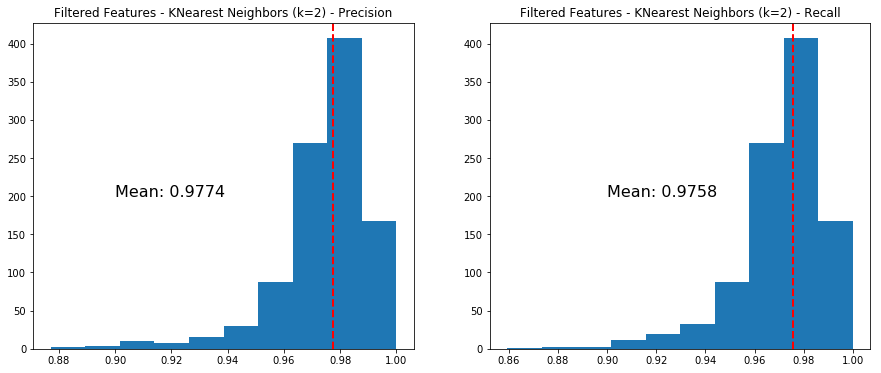

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - KNearest Neighbors (k=2) - Precision")
plt.annotate('Mean: '+str(round(precision_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - KNearest Neighbors (k=2) - Recall")
plt.annotate('Mean: '+str(round(recall_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.show()

<h1><a id="Results-c"></a>C. Random Forests</h1>

In [57]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                                  min_samples_split=2)
    cl11.fit(X_filtered_train, y_train)
    precision_scores.append(precision_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

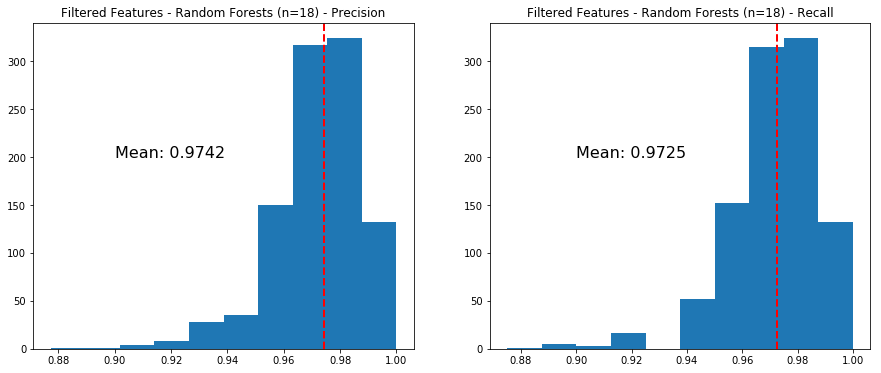

In [58]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (n=18) - Precision")
plt.annotate('Mean: '+str(round(precision_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (n=18) - Recall")
plt.annotate('Mean: '+str(round(recall_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.show()

<h1><a id="Results-d"></a>D. K Nearest Neighbors + Random Forests Voting</h1>

In [59]:
precision_scores = np.array([0., 0., 0., 0.])
recall_scores = np.array([0., 0., 0., 0.])
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl10 = KNeighborsClassifier(n_neighbors=2)
    cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                                  min_samples_split=2)
    cl12 = VotingClassifier(estimators=[('lr', cl10), ('rf', cl11)],
                            voting='soft')
    cl12.fit(X_filtered_train, y_train)
    precision_scores += precision_score(y_test, cl12.predict(X_filtered_test), average=None)
    recall_scores += recall_score(y_test, cl12.predict(X_filtered_test), average=None)
print(precision_scores/1000)
print(recall_scores/1000)

[ 0.97282364  1.          0.95518092  0.97255403]
[ 0.92356987  1.          1.          0.97432533]


In [60]:
precision_scores = []
recall_scores = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl10 = KNeighborsClassifier(n_neighbors=2)
    cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                                  min_samples_split=2)
    cl12 = VotingClassifier(estimators=[('lr', cl10), ('rf', cl11)],
                            voting='soft')
    cl12.fit(X_filtered_train, y_train)
    precision_scores.append(precision_score(y_test, cl12.predict(X_filtered_test), average="weighted"))
    recall_scores.append(recall_score(y_test, cl12.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

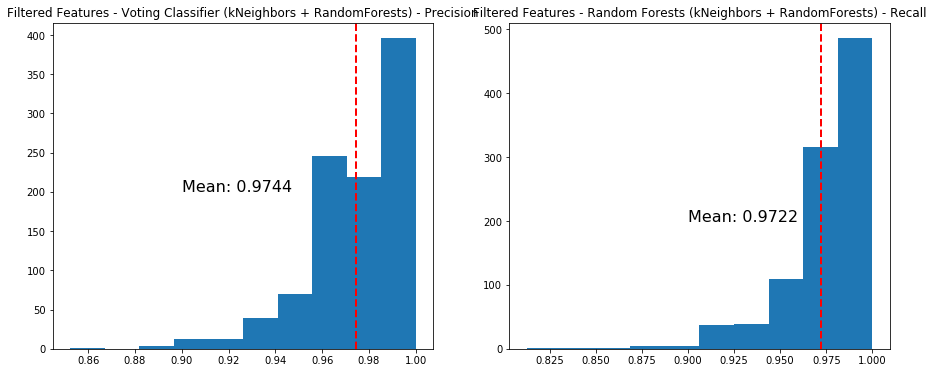

In [61]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Voting Classifier (kNeighbors + RandomForests) - Precision")
plt.annotate('Mean: '+str(round(precision_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (kNeighbors + RandomForests) - Recall")
plt.annotate('Mean: '+str(round(recall_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.show()

<h1 class="section-header"><a id="Classifiers-Multilabel"></a>Classifiers (Multilabel)</h1>

<h1><a id="Classifiers-Multilabel-a"></a>A. Feature Extraction</h1>

<h2><a id="Classifiers-Multilabel-a-i"></a>i. tsfresh</h2>

In [80]:
# y_value: [Tamper, Duplication, Dropping]

dataframes = [{'data':df_norm, 'y_value':[0, 0, 0]}, 
              {'data':df_tamper, 'y_value':[1, 0, 0]}, 
              {'data':df_dup, 'y_value':[0, 1, 0]}, 
              {'data':df_drop, 'y_value':[0, 0, 1]}, 
              {'data':df_dup_drop, 'y_value':[0, 1, 1]}, 
              {'data':df_dup_tamper, 'y_value':[1, 1, 0]},
              {'data':df_drop_tamper, 'y_value':[1, 0, 1]},
              {'data':df_drop_dup_tamper, 'y_value':[1, 1, 1]}]
y_store = []
df_store = []
sample_id = 0
for df_i in range(len(dataframes)):
    y_val = dataframes[df_i]['y_value']
    for chunk in np.split(np.array(getPacketSpeeds(dataframes[df_i]['data'])), 40):
        y_store.append(y_val)
        for chunk_i in range(len(chunk)):
            df_store.append({'id':sample_id, 'time':chunk_i, 'val':chunk[chunk_i]})
        sample_id += 1

df = pd.DataFrame(df_store)
y = np.array(y_store)

In [85]:
df

,id,time,val
0,0,0,291
1,0,1,284
2,0,2,289
3,0,3,275
4,0,4,280
5,0,5,283
6,0,6,267
7,0,7,275
8,0,8,278
9,0,9,274


In [83]:
y

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [101]:
y_str = pd.Series([(str(l[0])+str(l[1])+str(l[2])) for l in y])
y_str

0      000
1      000
2      000
3      000
4      000
5      000
6      000
7      000
8      000
9      000
10     000
11     000
12     000
13     000
14     000
15     000
16     000
17     000
18     000
19     000
20     000
21     000
22     000
23     000
24     000
25     000
26     000
27     000
28     000
29     000
      ... 
290    111
291    111
292    111
293    111
294    111
295    111
296    111
297    111
298    111
299    111
300    111
301    111
302    111
303    111
304    111
305    111
306    111
307    111
308    111
309    111
310    111
311    111
312    111
313    111
314    111
315    111
316    111
317    111
318    111
319    111
Length: 320, dtype: object

In [96]:
extraction_settings = ComprehensiveFCParameters()

In [230]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.14s/it]
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'

 'val__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [98]:
X.head()

variable,val__abs_energy,val__absolute_sum_of_changes,"val__agg_autocorrelation__f_agg_""mean""__maxlag_40","val__agg_autocorrelation__f_agg_""median""__maxlag_40","val__agg_autocorrelation__f_agg_""var""__maxlag_40","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","val__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","val__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,val__symmetry_looking__r_0.9,val__symmetry_looking__r_0.9500000000000001,val__time_reversal_asymmetry_statistic__lag_1,val__time_reversal_asymmetry_statistic__lag_2,val__time_reversal_asymmetry_statistic__lag_3,val__value_count__value_-1,val__value_count__value_0,val__value_count__value_1,val__variance,val__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1164282.0,84.0,-0.318277,-0.084787,0.458073,291.0,-1.0,-10.0,0.0,0.0,...,1.0,1.0,-327310.538462,-4.920471e+05,-8.003561e+05,0.0,0.0,0.0,37.982222,1.0
1,1237951.0,139.0,-0.360882,-0.189682,0.396928,295.0,1.0,6.0,0.0,0.0,...,1.0,1.0,481305.307692,1.094408e+06,1.451703e+06,0.0,0.0,0.0,84.515556,1.0
2,1289634.0,61.0,-0.067411,-0.174145,0.118556,299.0,-1.0,-3.0,0.0,0.0,...,1.0,1.0,-106346.230769,-6.222636e+04,-9.548111e+04,0.0,0.0,0.0,9.360000,1.0
3,1285611.0,65.0,-0.107310,-0.109689,0.281267,300.0,-1.0,-2.0,0.0,0.0,...,1.0,1.0,-65854.923077,-1.725083e+05,-3.579941e+05,0.0,0.0,0.0,14.595556,1.0
4,1284094.0,114.0,0.000876,0.012714,0.255850,301.0,-1.0,-5.0,0.0,0.0,...,1.0,1.0,-27088.615385,-1.081755e+05,1.350256e+04,0.0,0.0,0.0,30.515556,1.0


<h1><a id="Classifiers-Multilabel-b"></a>B. Feature Filtering</h1>

<h2><a id="Classifiers-Multilabel-b-i"></a>i. tsfresh</h2>

In [102]:
X_filtered = extract_relevant_features(df, y_str, 
                                       column_id='id', column_sort='time',
                                       default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  1.69s/it]
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'val__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'val__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'

 'val__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [103]:
X_filtered.head()

variable,"val__fft_aggregated__aggtype_""variance""","val__fft_aggregated__aggtype_""centroid""",val__sum_of_reoccurring_values,val__sum_of_reoccurring_data_points,"val__fft_aggregated__aggtype_""skew""","val__fft_aggregated__aggtype_""kurtosis""",val__binned_entropy__max_bins_10,val__minimum,val__cid_ce__normalize_True,val__partial_autocorrelation__lag_1,...,"val__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.4","val__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","val__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""stderr""","val__fft_coefficient__coeff_2__attr_""abs""","val__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","val__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","val__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","val__fft_coefficient__coeff_4__attr_""abs""",val__friedrich_coefficients__m_3__r_30__coeff_0,"val__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4"
id,,,,,,,,,,,,,,,,,,,,,
0,0.671843,0.138928,552.0,1104.0,6.510976,45.365282,2.083766,267.0,4.401987,0.179875,...,4.75,2.187500,3.025315,20.009578,0.0,24.187500,0.0,31.464841,54.29592,0.25
1,0.918603,0.189438,569.0,1138.0,5.584250,33.551005,2.153532,272.0,4.533479,0.199497,...,8.50,12.916667,8.336938,51.767483,3.0,84.472222,0.0,23.764165,54.29592,0.00
2,0.405701,0.077271,1174.0,2642.0,1.021008,6.028038,2.026230,288.0,6.244656,-0.323871,...,3.25,3.687500,1.293265,10.436189,0.0,6.687500,0.0,11.214867,54.29592,0.25
3,0.502010,0.097991,882.0,2351.0,7.741466,63.330613,1.951848,285.0,6.008900,-0.347486,...,1.00,0.000000,4.664990,5.446129,0.0,1.000000,1.0,25.048507,54.29592,0.00
4,0.699398,0.136813,881.0,2352.0,6.489552,44.494378,1.748971,283.0,6.536995,-0.534039,...,2.00,8.000000,8.198374,15.456904,0.0,8.000000,0.0,18.345876,54.29592,0.00


<h1><a id="Classifiers-Multilabel-c"></a>C. Machine Learning Models</h1>

In [139]:
def multilabel_score(X, Y):
    """ 
    Returns scoring metrics for multilabel classification results
    Returns dictionary with the following information
    All Correct: The proportion of samples where all the labels were identified correctly
    Average Accuracy: The proportion of all labels that were correctly identified
    Normal vs. Threat Accuracy: The proportion of labels where Normal vs. Threat was correctly distinguished   
    
    Parameters
    X: ndarray of predictions
    Y: ndarray of answers
    """
    if (X.shape != Y.shape):
        return "ERROR: X and Y do not have the same dimensions"
    
    length = X.shape[0]
    width = X.shape[1]
    total_correct = 0
    all_correct = 0
    normal_threat_correct = 0
    for length_i in range(length):
        if (np.array_equal(X[length_i], Y[length_i])):
            all_correct += 1
        total_correct += np.absolute(X[length_i] == Y[length_i]).sum()
        if ((np.sum(X[length_i]) == 0 and np.sum(Y[length_i]) == 0) or 
            (np.sum(X[length_i]) != 0 and np.sum(Y[length_i]) != 0)):
            normal_threat_correct += 1
        
    return {'All Correct': all_correct/length, 
            'Average Accuracy': total_correct/(length*width), 
            'Normal vs. Threat Accuracy': normal_threat_correct/length}

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)

parameters = {'k': range(1,5), 's': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
score = 'f1_macro'

clf = GridSearchCV(MLkNN(), parameters, scoring=score)
clf.fit(X_filtered, y)

print (clf.best_params_, clf.best_score_)

{'k': 3, 's': 0.5} 0.662876907507


In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)

classifier = MLkNN(k=3, s=0.5)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
multilabel_score(predictions.toarray(), y_test)

{'All Correct': 0.703125,
 'Average Accuracy': 0.88541666666666663,
 'Normal vs. Threat Accuracy': 0.9921875}

In [203]:
all_correct_scores = []
average_accuracy_scores = []
normal_threat_accuracy_scores = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)
    classifier = MLkNN(k=3, s=0.5)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    results = multilabel_score(predictions.toarray(), y_test)
    all_correct_scores.append(results['All Correct'])
    average_accuracy_scores.append(results['Average Accuracy'])
    normal_threat_accuracy_scores.append(results['Normal vs. Threat Accuracy'])
all_correct_scores = np.array(all_correct_scores)
average_accuracy_scores = np.array(average_accuracy_scores)
normal_threat_accuracy_scores = np.array(normal_threat_accuracy_scores)

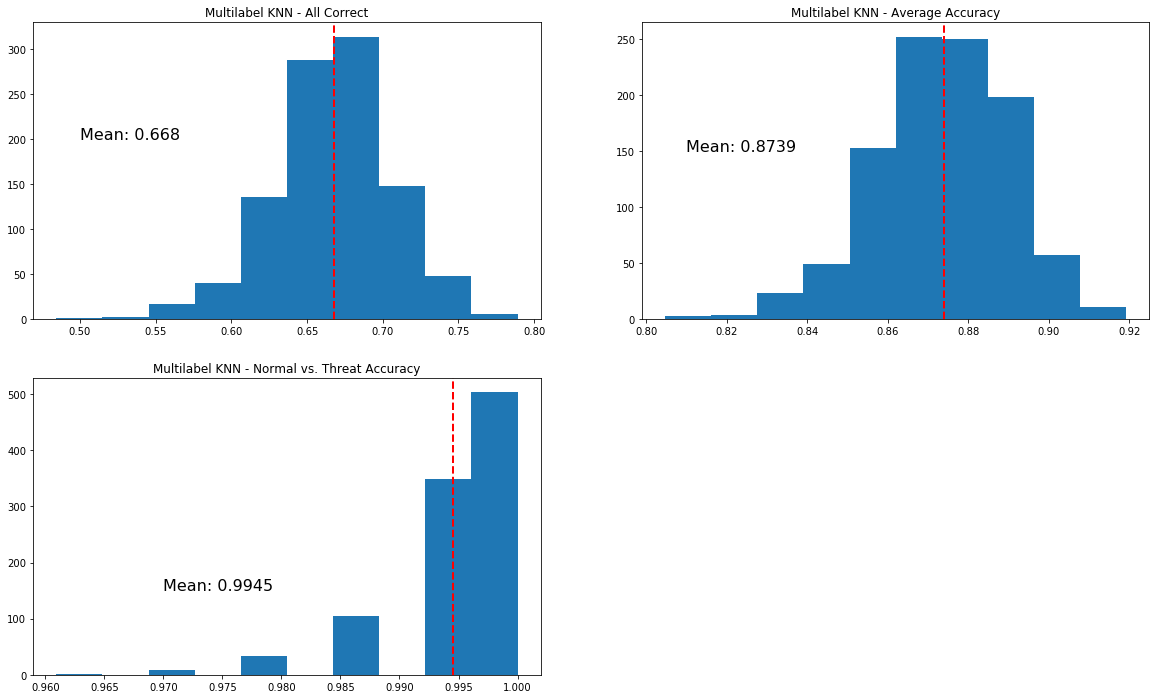

In [225]:
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.hist(all_correct_scores)
plt.axvline(all_correct_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.annotate('Mean: '+str(round(all_correct_scores.mean(), 4)), xy=(0.5, 50), xytext=(0.5, 200), size=16)
plt.title("Multilabel KNN - All Correct")
plt.subplot(2, 2, 2)
plt.hist(average_accuracy_scores)
plt.axvline(average_accuracy_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.annotate('Mean: '+str(round(average_accuracy_scores.mean(), 4)), xy=(0.81, 50), xytext=(0.81, 150), size=16)
plt.title("Multilabel KNN - Average Accuracy")
plt.subplot(2, 2, 3)
plt.hist(normal_threat_accuracy_scores)
plt.axvline(normal_threat_accuracy_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.annotate('Mean: '+str(round(normal_threat_accuracy_scores.mean(), 4)), xy=(0.97, 150), xytext=(0.97, 150), size=16)
plt.title("Multilabel KNN - Normal vs. Threat Accuracy")
plt.show()

In [226]:
multilabel_score(np.array([[0,0,0]]), np.array([[0,0,0]]))

{'All Correct': 1.0,
 'Average Accuracy': 1.0,
 'Normal vs. Threat Accuracy': 1.0}

In [227]:
multilabel_score(predictions.toarray(), y_test)

{'All Correct': 0.6953125,
 'Average Accuracy': 0.8828125,
 'Normal vs. Threat Accuracy': 1.0}

In [62]:
%%html
<style>
.notebook-title {
    text-align: center;
    background-color: #124391;
    padding: 30px;
    color: white;
}

.section-header {
    text-align: center;
    background-color: gray;
    padding: 30px;
    color: white;
}

.outline {
    width: 400px;
    margin: auto;
}  

</style>